# Exploration of Sanaga set

## Create overviews of recordings

In [1]:
import os
import glob
import pandas as pd
import datetime
import re
import subprocess

def read_files_vocalizations(raven_path):
    os.chdir(raven_path)
    recorder = []
    num_vocalizations = []
    filelist = []

    for file in glob.glob('*.txt'):
        matchObj=re.search("A[0-9]+", file)
        recorder.append(matchObj.group())
        num_vocalizations.append(count_vocalizations(file, 'Chimpanzee'))
        filelist.append(file)

    d = {'file': filelist, 'recorder':recorder,'vocalizations':num_vocalizations}
    return pd.DataFrame(d)

def get_folder_stats(path, recorder):
    os.chdir(path + recorder + '/')
    df = pd.DataFrame(glob.glob('*.WAV'))

    df.columns = ['files']
    df = df.sort_values('files', ignore_index=True)

    startstr = str(list(df.iloc[0])[0][:-4])
    endstr = str(list(df.iloc[-1])[0][:-4])

    starttime=datetime.datetime.strptime(startstr, "%Y%m%d_%H%M%S")
    endtime = datetime.datetime.strptime(endstr, "%Y%m%d_%H%M%S")
    duration = endtime-starttime

    return [recorder, starttime, endtime, duration]

def list_folder_stats(path):
    data = []
    
    for recorder in os.listdir(path):
        data.append(get_folder_stats(path, recorder))
    return pd.DataFrame(data, columns=['recorder', 'start', 'end', 'duration'])

def count_vocalizations(file, species):
    df = process_raven(file, species)
    return df.shape[0]

def process_raven(file, species):
    df = pd.read_table(file)
    df.columns = df.columns.str.lower()
    df = df.loc[(df['class'] == species)]
    df = df.rename(columns={'begin path': 'begin_path', 'end path': 'end_path'})
    df['begin_path'] = df['begin_path'].str.replace('.*\\\\','', regex=True)
    df['begin_path'] = df['begin_path'].str.replace('\.WAV','', regex=True)
    df['end_path'] = df['end_path'].str.replace('.*\\\\','', regex=True)
    df['end_path'] = df['end_path'].str.replace('\.WAV','', regex=True)
    df['start_time'] = df['file offset (s)']
    df['end_time'] = (df['file offset (s)']
                            + df['end time (s)'] - df['begin time (s)'])
    df = df_file_to_timestamp(df)
    return df

def read_processed_csv(path, recorder):
    df = pd.read_csv(path + recorder  + '.csv')
    df["start_datetime"] = pd.to_datetime(df["start_datetime"])
    df["end_datetime"] = pd.to_datetime(df["end_datetime"])
    return df

def df_file_to_timestamp(df):
    df['timestamp_beginfile'] = pd.to_datetime(df['begin_path'], format="%Y%m%d_%H%M%S")
    df['timestamp_endfile'] = pd.to_datetime(df['end_path'], format="%Y%m%d_%H%M%S")
    df['delta_t'] = df['timestamp_endfile']-df['timestamp_beginfile']
    return df

def wav_list(base_wav_path, recorder):
    wav_path = base_wav_path + recorder + '/'
    filelist = sorted(os.listdir(wav_path))
    filelist = list(filter(lambda k: 'WAV' in k, filelist))
    filelist = [sub[ : -4] for sub in filelist]
    return filelist

def yoda_get(file, source, dest):
    filepath = source + file
    p = subprocess.Popen(['iget', filepath, dest])
    p.wait()

In [2]:
path = '/run/user/1000/gvfs/dav:host=science.data.uu.nl,ssl=true/research-zwerts/data/sanaga/'
raven_path = '/home/jelle/Repositories/animalsounds/data/raven_annotations/sanaga/'
#path = '/home/jelle/Repositories/animalsounds/data/sanaga/'

df_overview = list_folder_stats(path)
df_vocalizations = read_files_vocalizations(raven_path)
df_summary = df_overview.merge(df_vocalizations, how='left', on='recorder')
df_summary = df_summary.dropna()
df_summary['vocalizations'] = df_summary['vocalizations'].astype(int)
df_summary

,recorder,start,end,duration,file,vocalizations
0,A1,2021-02-18 12:07:47,2021-02-24 06:42:00,5 days 18:34:13,20210218_120747.Table.1.selections.A1.adjusted...,279
1,A11,2021-02-18 09:42:03,2021-02-19 16:32:00,1 days 06:49:57,20210218_094203.Table.1.selections.A11.adjuste...,0
2,A21,2021-02-18 11:52:07,2021-02-22 16:35:00,4 days 04:42:53,20210218_115207.Table.1.selections.SanagaYong....,422
3,A22,2021-02-18 09:17:35,2021-02-19 19:34:00,1 days 10:16:25,20210218_091735.Table.1.selections-A22_correct...,54
4,A23,1970-01-01 01:14:32,1970-01-01 01:17:37,0 days 00:03:05,19700101_011432.Table.1.selections A23_JZ.txt,29
5,A26,2021-02-18 16:07:59,2021-02-20 15:00:00,1 days 22:52:01,20210218_160759.Table.1.selections.A26.adjuste...,27
6,A3,2021-02-18 12:45:06,2021-02-22 18:36:00,4 days 05:50:54,20210218_124506.Table.1.selections.A3.adjusted...,200
7,A38,2021-02-18 15:33:18,2021-02-24 15:34:00,6 days 00:00:42,20210218_153318.Table.1.selections A38_JZ.txt,592
8,A4,2021-02-18 13:04:06,2021-02-23 21:42:00,5 days 08:37:54,20210218_130406.Table.1.selections.txt A4_corr...,182
9,A40,1970-01-01 01:00:18,1970-01-07 14:58:06,6 days 13:57:48,19700101_010018.Table.1.selections.txt A40_JZ.txt,26


In [3]:
transects = {'recorder':['A6', 'A2', 'A22', 'A5', 'A11', 'A21', 'A1', 'A23', 'A3', 'A4', 'A38', 'A31', 'A26', 'A40'], 
             'transect':['Mintak', 'Mintak', 'Mintak', 'Mintak', 'Mintak', 'Jacky', 'Jacky', 'Jacky', 'Jacky', 'Jacky', 'Bikols', 'Bikols', 'Bikols', 'Bikols'],
             'Distance':[0, 200, 400, 600, 800, 0, 200, 400, 600, 800, 0, 200, 400, 600]}
df_transects = pd.DataFrame(transects)
df_transects

,recorder,transect,Distance
0,A6,Mintak,0
1,A2,Mintak,200
2,A22,Mintak,400
3,A5,Mintak,600
4,A11,Mintak,800
5,A21,Jacky,0
6,A1,Jacky,200
7,A23,Jacky,400
8,A3,Jacky,600
9,A4,Jacky,800


# Process raven files and save csv files of processed data
Output will be a csv file per folder with filenames (.WAV) and respective timestamps of start and end time per vocalization

In [51]:
raven_path = '/home/jelle/Repositories/animalsounds/data/raven_annotations/sanaga/'

In [52]:
file = raven_path + '20210218_153318.Table.1.selections A38_JZ.txt'
species = 'Chimpanzee'
num_vocal = count_vocalizations(file, species)
num_vocal


592

In [53]:
import librosa
# Create file list
def fix_multifile(df_out, filelist, wav_path):
    row_i = list(df_out[(df_out['begin_path']
                         != df_out['end_path'])].index)
    for i in row_i:
        last_index = df_out.index[-1]
        filelength = librosa.get_duration(filename=wav_path + df_out.loc[i, 'begin_path'] + '.WAV')
        
        df = pd.DataFrame([[df_out.loc[i, 'begin_path'],
                            df_out.loc[i, 'begin_path'],
                            df_out.loc[i, 'start_time'],
                            filelength],
                           [df_out.loc[i, 'end_path'],
                            df_out.loc[i, 'end_path'],
                            0.0,
                            df_out.loc[i, 'end_time']-filelength]],
                          columns=['begin_path',
                                   'end_path',
                                   'start_time',
                                   'end_time'])
        df.index = [last_index+1, last_index+2]
        df_out = df_out.append(df, ignore_index=False)

        if df_out.loc[i, 'delta_t'].total_seconds() > 65:
            for j in range(filelist.index(df_out.loc[i, 'begin_path'])
                           + 1, filelist.index(df_out.loc[i, 'end_path'])):
               
                last_index = df_out.index[-1]
                df = pd.DataFrame([[filelist[j],
                                    filelist[j],
                                    0.0,
                                    librosa.get_duration(filename=wav_path + filelist[j] + '.WAV')]],
                                  columns=['begin_path',
                                           'end_path',
                                           'start_time',
                                           'end_time'])
                df.index = [last_index+1]
            df_out = df_out.append(df, ignore_index=False)
    return df_out.drop(row_i)

In [54]:
# drop irrelevant columns
def clean_up(df):
    df = df.loc[:, ['begin_path', 
                    'start_time', 
                    'end_time']]
    df = df.drop(df[df['end_time'] - df['start_time'] < 0.2].index)
    df = df.reset_index()
    df = df.drop(columns=['index'])
    df['start_datetime'] = pd.to_datetime(df['begin_path'], format="%Y%m%d_%H%M%S") + \
                           pd.to_timedelta(df['start_time'], unit='seconds')
    df['end_datetime'] = pd.to_datetime(df['begin_path'], format="%Y%m%d_%H%M%S") + \
                         pd.to_timedelta(df['end_time'], unit='seconds')
    return df

In [21]:
base_wav_path = '/run/user/1000/gvfs/dav:host=science.data.uu.nl,ssl=true/research-zwerts/data/sanaga/'



for index, f in enumerate(list(df_summary['file'])):
    
    file = raven_path + f
    species = 'Chimpanzee'
    recorder = re.search("A[0-9]+", f).group(0)
    
    print(recorder)

    filelist = wav_list(base_wav_path, recorder)
    df = process_raven(file, species)
    df = fix_multifile(df, filelist, wav_path)

    df = clean_up(df)
    df['recorder'] = recorder
    df.to_csv('/home/jelle/Repositories/animalsounds/data/raven_annotations/sanaga_processed/' + recorder  + '.csv')
    if index == 0:
        df_all = df
    else:
        df_all.append(df, ignore_index=True)


A1
20210218_233202.WAV
20210218_233302.WAV
20210218_233502.WAV
20210218_233802.WAV
20210218_234002.WAV
20210218_234402.WAV
20210218_234602.WAV
20210219_033602.WAV
20210219_033702.WAV
20210219_034302.WAV
20210219_034402.WAV
20210219_104702.WAV
20210219_104802.WAV
20210219_235902.WAV
20210220_000102.WAV
20210220_000202.WAV
20210220_000402.WAV
20210220_000602.WAV
20210220_000702.WAV
20210220_000802.WAV
20210220_000902.WAV
20210220_001102.WAV
20210220_001202.WAV
20210221_005503.WAV
20210221_005803.WAV
20210221_005903.WAV
20210221_010203.WAV
20210221_010303.WAV
20210221_010403.WAV
20210221_010503.WAV
20210221_010603.WAV
20210221_010703.WAV
20210221_011103.WAV
20210221_011203.WAV
20210221_011403.WAV
20210221_034103.WAV
20210221_034203.WAV
20210221_034403.WAV
20210221_034703.WAV
20210221_034803.WAV
20210221_034903.WAV
20210221_035003.WAV
20210221_035103.WAV
20210221_035303.WAV
20210221_035403.WAV
20210221_035503.WAV
20210221_035603.WAV
20210221_035803.WAV
20210221_040003.WAV
20210221_040603.W

In [56]:
# The cell above for a single recorder
base_wav_path = '/run/user/1000/gvfs/dav:host=science.data.uu.nl,ssl=true/research-zwerts/data/sanaga/'
recorder = 'A38'
wav_path = base_wav_path + recorder + '/'
filelist = wav_list(base_wav_path, recorder)
df = process_raven(file, species)
df = fix_multifile(df, filelist, wav_path)

df = clean_up(df)
df['recorder'] = recorder
df.to_csv('/home/jelle/Repositories/animalsounds/data/raven_annotations/sanaga_processed/' + recorder  + '.csv')

In [ ]:
yodapath = '/nluu6p/home/research-zwerts/data/sanaga/A6/'
destination = '/home/jelle/Repositories/animalsounds/data/sanaga/A6/'

# create Unique list 
for file in list(df['begin_path'].unique()):
    
    print(file + '.WAV')
    yoda_get(file + '.WAV', yodapath, destination)

# Find vocalizations in A6 & A22

In [11]:
## Change order, first fix multifile, then timestamps

## get 2 dataframes
processed_path = '/home/jelle/Repositories/animalsounds/data/raven_annotations/sanaga_processed/'





df6 = read_processed_csv(processed_path, recorder = 'A6')
recorder = 'A22'
df22 = read_processed_csv(processed_path, recorder = 'A22')


In [12]:
## Calculate fraction found based on timestamps
### calculate df22 extent (create function cell 1)
path = '/run/user/1000/gvfs/dav:host=science.data.uu.nl,ssl=true/research-zwerts/data/sanaga/'
recorder = 'A22'
A22_overview = get_folder_stats(path, recorder)
A22_overview



['A22',
 datetime.datetime(2021, 2, 18, 9, 17, 35),
 datetime.datetime(2021, 2, 19, 19, 34),
 datetime.timedelta(days=1, seconds=36985)]

In [13]:
from collections import deque

### create df6 subset
df6_subset = df6[(df6["start_datetime"] > A22_overview[1]) & (df6["end_datetime"] < A22_overview[2])]

## sort dataframes
df22 = df22.sort_values(by='start_datetime')
df6_subset = df6_subset.sort_values(by='start_datetime')

# WITHIN
main = deque(list(df6_subset[["start_datetime", "end_datetime"]].itertuples(index=False, name=None)))
dist = deque(list(df22[["start_datetime", "end_datetime"]].itertuples(index=False, name=None)))

dist_start, dist_end = dist[0]

dist[0][0]

Timestamp('2021-02-18 09:20:13.161600')

In [34]:
pd.options.display.max_rows = 100
display(df22)
pd.options.display.max_rows = 10

,Unnamed: 0,begin_path,start_time,end_time,start_datetime,end_datetime,recorder
0,0,20210218_092002,11.1616,19.083235,2021-02-18 09:20:13.161600000,2021-02-18 09:20:21.083234884,A22
41,41,20210218_094802,35.2952,58.000000,2021-02-18 09:48:37.295200000,2021-02-18 09:49:00.000000000,A22
42,42,20210218_094902,0.0000,32.044776,2021-02-18 09:49:02.000000000,2021-02-18 09:49:34.044775763,A22
1,1,20210218_095002,9.5421,25.442967,2021-02-18 09:50:11.542100000,2021-02-18 09:50:27.442966888,A22
2,2,20210218_095002,33.8451,44.505908,2021-02-18 09:50:35.845100000,2021-02-18 09:50:46.505908482,A22
43,43,20210218_095002,53.9049,58.000000,2021-02-18 09:50:55.904900000,2021-02-18 09:51:00.000000000,A22
44,44,20210218_095102,0.0000,7.375832,2021-02-18 09:51:02.000000000,2021-02-18 09:51:09.375832271,A22
33,33,20210218_095202,21.7510,32.966412,2021-02-18 09:52:23.751000000,2021-02-18 09:52:34.966411566,A22
45,45,20210218_095802,54.6788,58.000000,2021-02-18 09:58:56.678800000,2021-02-18 09:59:00.000000000,A22
46,46,20210218_095902,0.0000,3.364392,2021-02-18 09:59:02.000000000,2021-02-18 09:59:05.364391760,A22


In [14]:
hit_types = []
new_time = 0.0
within_time = 0.0
not_found = 0.0
margins = 0.0

while(len(dist) > 0):
    dist_start, dist_end = dist[0]
    
    while(len(main) > 0):
        main_start, main_end = main[0]
        if len(hit_types) > 0:
            print(hit_types[-1])
        if main_end < dist_start:
            #            <----- dist ----->
            # <-main->
            # main vocalization did not reach a dist vocalization yet
            # remove the current vocalization, move to the next
            hit_types.append(('main before dist', new_time, main_start, 
                main_end, dist_start, dist_end))
            
            not_found += (main_end - main_start).total_seconds()
            main.popleft()
            # break the while loop to start next
            
        elif main_start <= dist_start and main_end >= dist_end:
            #    <------- dist ------->       <--?dist?-->
            # <---------- main ----------------------------->
            # this is what we expect
            within_time += (dist_end - dist_start).total_seconds()
            margins += (dist_start - main_start).total_seconds()
            
            # However if there is another distant inside 
            # the main vocalization we need to account for this (MAYBE NOT NEEDED IF WE JUST NEED WITHIN TIME)
            if len(dist) > 1:
                if dist[1][0] < main_end:
                    print("TWO distant contained")
                    margins += (main_end - dist_end).total_seconds()
                    if dist[2][0] < main_end:
                        print("CHAOS")
                        
                    if main_end <= dist[1][1]:
                        within_time += (main_end - dist_start).total_seconds()
                        new_time += (dist_end - main_end).total_seconds()
                    else:
                        within_time += (dist_end - dist_start).total_seconds()
                        margins += (main_end - dist_end).total_seconds()
                    dist.popleft()
                else:
                    margins += (main_end - dist_end).total_seconds()
            else:
                margins += (main_end - dist_end).total_seconds()
            
            hit_types.append(('perfect', new_time, main_start, 
                            main_end, dist_start, dist_end))

            dist.popleft()
            break
            
        elif main_start <= dist_start and main_end > dist_start and main_end <= dist_end:
            #          <----- dist ----->
            # <-----main-------->
            # this is bad
            within_time += (main_end - dist_start).total_seconds()
            new_time += (dist_end - main_end).total_seconds()
            hit_types.append(('distant vocalization ends too late', new_time, main_start, 
                            main_end, dist_start, dist_end))
            # remove the current negative interval
            main.popleft()
            # and break the loop to start with the next negative interval
            
        elif main_start >= dist_start and main_end <= dist_end:
            #    <----- dist ----->
            #         <-main-> <----main->
            # this is bad
            within_time += (main_end - main_start).total_seconds()
            new_time += (main_start - dist_start).total_seconds()
            new_time += (dist_end - main_end).total_seconds()
            hit_types.append(('distant voc is longer on both sides', new_time, main_start, 
                            main_end, dist_start, dist_end))
            # remove the current negative interval
            main.popleft()
            # and break the loop to start with the next dist interval (REMOVE this break???, yes we probably could, but we have to fix the new_time then, AND check the "else" part)
            
        elif main_start >= dist_start and main_start < dist_end and main_end >= dist_end:
            #    <----- dist ----->
            #                 <-main->
            # this is bad
            within_time += (dist_end - main_start).total_seconds()
            new_time += (main_start - dist_start).total_seconds()
            hit_types.append(('distant vocalization starts too soon',  new_time, main_start, 
                            main_end, dist_start, dist_end))
            # remove the current negative interval
            dist.popleft()
            # and break the loop to start with the next negative interval
            break
        else:
            #  <----- dist ----->
            #                     <----main----->
            # Not found before!
            hit_types.append(('dist before main', new_time, main_start, 
                main_end, dist_start, dist_end))
            new_time += (dist_end - dist_start).total_seconds()
            dist.popleft()
            break
        # if there are no more positive intervals we can quit for this file
        print(len(dist))
        if len(dist) == 0:
            main = [] 
        
              

            
### Wat willen we vinden??
## Hoeveel van de A6 vocalizaties zijn ook in A22 te horen? >>> Within time


## Hoeveel van de A6 vocalizaties zijn niet in A22 te horen? Total_A6 - within time
## Hoeveel van A22 is nieuw? Total_A22 - within time

### Hist vocalization lengths
### (Ideally keep 1 second margin)
# _________________|-----|________________
# ___________|--------|___________________
# _____________|----|_____________________

#### Register all df22 parts starting >1 second before/after df6 starttime as new/within? and ignore parts <1 second from starttime?

# ratio new/within (or new/all)

# create test set 
##random sample chimps (with 1 second margin)


## random sample background (based on timestamps ??)







#os.chdir('/home/jelle/Repositories/animal-sounds/bioacoustics/2_wav_processing')
#from raven_to_wav import ProcessRaven
    
#wav_path = '/run/user/1000/gvfs/dav:host=science.data.uu.nl,ssl=true/research-zwerts/data/sanaga/A6/'    
    
#filelist = sorted(os.listdir(wav_path))

# timestamps

# filter larger set (to match smaller dataset)

67
('main before dist', 0.0, Timestamp('2021-02-18 09:18:51.512499999'), Timestamp('2021-02-18 09:19:00'), Timestamp('2021-02-18 09:20:13.161600'), Timestamp('2021-02-18 09:20:21.083234884'))
67
('main before dist', 0.0, Timestamp('2021-02-18 09:19:02'), Timestamp('2021-02-18 09:19:02.317207378'), Timestamp('2021-02-18 09:20:13.161600'), Timestamp('2021-02-18 09:20:21.083234884'))
67
('main before dist', 0.0, Timestamp('2021-02-18 09:19:31.888800'), Timestamp('2021-02-18 09:19:34.639765060'), Timestamp('2021-02-18 09:20:13.161600'), Timestamp('2021-02-18 09:20:21.083234884'))
('dist before main', 0.0, Timestamp('2021-02-18 09:28:03.062000'), Timestamp('2021-02-18 09:28:11.457186105'), Timestamp('2021-02-18 09:20:13.161600'), Timestamp('2021-02-18 09:20:21.083234884'))
66
('main before dist', 7.921634, Timestamp('2021-02-18 09:28:03.062000'), Timestamp('2021-02-18 09:28:11.457186105'), Timestamp('2021-02-18 09:48:37.295200'), Timestamp('2021-02-18 09:49:00'))
66
('main before dist', 7.9

In [15]:
total_A6 = (df6_subset["end_datetime"] - df6_subset["start_datetime"]).sum().total_seconds()
total_A22 = (df22["end_datetime"] - df22["start_datetime"]).sum().total_seconds()

### Wat willen we vinden??
## Hoeveel van de A6 vocalizaties zijn ook in A22 te horen? >>> Within time
print("Within time = " + str(within_time))

## Hoeveel van de A6 vocalizaties zijn niet in A22 te horen? Total_A6 - within time
print("Not found = " + str(total_A6 - within_time))

## Hoeveel van A22 is nieuw? Total_A22 - within time
print("New found = " + str(total_A22 - within_time))

Within time = 734.2279359999999
Not found = 2714.5808370000004
New found = 94.83206800000016


In [50]:
#df6_subset["duration [s]"] = 
total_A6 = (df6_subset["end_datetime"] - df6_subset["start_datetime"]).sum().total_seconds()
total_A22 = (df22["end_datetime"] - df22["start_datetime"]).sum().total_seconds()

3448.808773

In [29]:
for i in range(1, len(hit_types)):
    if (hit_types[i-1][0] == 'main before dist') and hit_types[i][0] == 'dist before main':
        print(str(i) + "is not found")

3is not found


# Run for all recorders

In [4]:
from collections import deque

def read_processed_csv(path, recorder):
    df = pd.read_csv(path + recorder  + '.csv')
    df["start_datetime"] = pd.to_datetime(df["start_datetime"])
    df["end_datetime"] = pd.to_datetime(df["end_datetime"])
    return df

def overlap(main, dist):
    hit_types = []
    within_time = 0.0
    dist_start, dist_end = dist[0]
    
    while(len(dist) > 0):
        dist_start, dist_end = dist[0]

        while(len(main) > 0):
            main_start, main_end = main[0]
            #if len(hit_types) > 0:
                #print(hit_types[-1])
            if main_end < dist_start:
                #            <----- dist ----->
                # <-main->
                # main vocalization did not reach a dist vocalization yet
                # remove the current vocalization, move to the next
                hit_types.append(('main before dist', main_start, 
                    main_end, dist_start, dist_end))

                main.popleft()
                # break the while loop to start next

            elif main_start <= dist_start and main_end >= dist_end:
                #    <------- dist ------->       <--?dist?-->
                # <---------- main ----------------------------->
                # this is what we expect
                within_time += (dist_end - dist_start).total_seconds()

                # However if there is another distant inside 
                # the main vocalization we need to account for this (MAYBE NOT NEEDED IF WE JUST NEED WITHIN TIME)
                if len(dist) > 1:
                    if dist[1][0] < main_end:
                        print("TWO distant contained")
                        if dist[2][0] < main_end:
                            print("CHAOS")

                        if main_end <= dist[1][1]:
                            within_time += (main_end - dist_start).total_seconds()
                        else:
                            within_time += (dist_end - dist_start).total_seconds()
                        dist.popleft()
                    #else:
                        
                #else:

                hit_types.append(('perfect', main_start, 
                                main_end, dist_start, dist_end))

                dist.popleft()
                break

            elif main_start <= dist_start and main_end > dist_start and main_end <= dist_end:
                #          <----- dist ----->
                # <-----main-------->
                # this is bad
                within_time += (main_end - dist_start).total_seconds()
                hit_types.append(('distant vocalization ends too late', main_start, 
                                main_end, dist_start, dist_end))
                # remove the current negative interval
                main.popleft()
                # and break the loop to start with the next negative interval

            elif main_start >= dist_start and main_end <= dist_end:
                #    <----- dist ----->
                #         <-main-> <----main->
                # this is bad
                within_time += (main_end - main_start).total_seconds()
                hit_types.append(('distant voc is longer on both sides', main_start, 
                                main_end, dist_start, dist_end))
                # remove the current negative interval
                main.popleft()
                # and break the loop to start with the next dist interval (REMOVE this break???, yes we probably could, but we have to fix the new_time then, AND check the "else" part)

            elif main_start >= dist_start and main_start < dist_end and main_end >= dist_end:
                #    <----- dist ----->
                #                 <-main->
                # this is bad
                within_time += (dist_end - main_start).total_seconds()
                hit_types.append(('distant vocalization starts too soon', main_start, 
                                main_end, dist_start, dist_end))
                # remove the current negative interval
                dist.popleft()
                # and break the loop to start with the next negative interval
                break
            else:
                #  <----- dist ----->
                #                     <----main----->
                # Not found before!
                hit_types.append(('dist before main', main_start, 
                    main_end, dist_start, dist_end))
                dist.popleft()
                break
            # if there are no more positive intervals we can quit for this file
            #print(len(dist))
            if len(dist) == 0:
                main = [] 
    return within_time, hit_types

def calculate_totals(df_main, df_dist, within_time):
    total_main = (df_main["end_datetime"] - df_main["start_datetime"]).sum().total_seconds()
    totals = {'recorder': [rec_dist], 
             'total_main': total_main,
             'within_sec': within_time,
             'not_found': total_main - within_time,
             'new_found': (df_dist["end_datetime"] - df_dist["start_datetime"]).sum().total_seconds()- within_time}

    return pd.DataFrame(totals)


processed_path = '/home/jelle/Repositories/animalsounds/data/raven_annotations/sanaga_processed/'
path = '/run/user/1000/gvfs/dav:host=science.data.uu.nl,ssl=true/research-zwerts/data/sanaga/'

df_totals = pd.DataFrame(
    columns=['recorder', 'total_main', 'within_sec', 'not_found', 'new_found'])


for rec_main in ['A6', 'A21', 'A38']:
    
    df_main = read_processed_csv(processed_path, recorder = rec_main)
    main_folder_stats = get_folder_stats(path, rec_main)
    
    if rec_main == 'A6':
        transect = ['A22', 'A5']
    elif rec_main == 'A21':
        transect = ['A1', 'A3', 'A4']
    else:
        transect = ['A26']
        
    for rec_dist in transect:
        
        print(rec_dist)
        
        df_dist = read_processed_csv(processed_path, recorder = rec_dist)

        ## Calculate fraction found based on timestamps

        dist_folder_stats = get_folder_stats(path, rec_dist)

        ### create df6 subset SUBSET VICE VERSA (dist longer than main)
        df_main_subset = df_main[(df_main["start_datetime"] > dist_folder_stats[1]) & (df_main["end_datetime"] < dist_folder_stats[2])]
        df_dist = df_dist[(df_dist["start_datetime"] > main_folder_stats[1]) & (df_dist["end_datetime"] < main_folder_stats[2])]

        ## sort dataframes
        df_dist = df_dist.sort_values(by='start_datetime')
        df_main_subset = df_main_subset.sort_values(by='start_datetime')

        main = deque(list(df_main_subset[["start_datetime", "end_datetime"]].itertuples(index=False, name=None)))
        dist = deque(list(df_dist[["start_datetime", "end_datetime"]].itertuples(index=False, name=None)))
        within_time, hit_types = overlap(main, dist)
       
        df = calculate_totals(df_main_subset, df_dist, within_time)
        
        df_totals = df_totals.append(df)
#                      
df_totals


A22
TWO distant contained
TWO distant contained
A5
A1
A3
TWO distant contained
CHAOS
A4
A26


,recorder,total_main,within_sec,not_found,new_found
0,A22,3448.808773,734.227936,2714.580837,94.832068
0,A5,3428.047396,34.946428,3393.100968,98.105839
0,A1,4151.238105,2654.997752,1496.240353,1897.610564
0,A3,4151.238105,2564.581564,1586.656541,2375.669887
0,A4,4151.238105,2428.111675,1723.126430,3789.070664
0,A26,1998.151680,417.633786,1580.517894,236.712144


In [15]:
df_totals['fraction_found'] = df_totals['within_sec']/df_totals['total_main'] 

test = pd.merge(df_summary, df_transects)
df_final = pd.merge(test, df_totals, how='left')
df_final

,recorder,start,end,duration,file,vocalizations,transect,Distance,total_main,within_sec,not_found,new_found,fraction_found
0,A1,2021-02-18 12:07:47,2021-02-24 06:42:00,5 days 18:34:13,20210218_120747.Table.1.selections.A1.adjusted...,279,Jacky,200,4151.238105,2654.997752,1496.240353,1897.610564,0.639568
1,A11,2021-02-18 09:42:03,2021-02-19 16:32:00,1 days 06:49:57,20210218_094203.Table.1.selections.A11.adjuste...,0,Mintak,800,NaN,NaN,NaN,NaN,NaN
2,A21,2021-02-18 11:52:07,2021-02-22 16:35:00,4 days 04:42:53,20210218_115207.Table.1.selections.SanagaYong....,422,Jacky,0,NaN,NaN,NaN,NaN,NaN
3,A22,2021-02-18 09:17:35,2021-02-19 19:34:00,1 days 10:16:25,20210218_091735.Table.1.selections-A22_correct...,54,Mintak,400,3448.808773,734.227936,2714.580837,94.832068,0.212893
4,A26,2021-02-18 16:07:59,2021-02-20 15:00:00,1 days 22:52:01,20210218_160759.Table.1.selections.A26.adjuste...,27,Bikols,400,1998.151680,417.633786,1580.517894,236.712144,0.209010
5,A3,2021-02-18 12:45:06,2021-02-22 18:36:00,4 days 05:50:54,20210218_124506.Table.1.selections.A3.adjusted...,200,Jacky,600,4151.238105,2564.581564,1586.656541,2375.669887,0.617787
6,A38,2021-02-18 15:33:18,2021-02-24 15:34:00,6 days 00:00:42,20210218_153318.Table.1.selections A38_JZ.txt,592,Bikols,0,NaN,NaN,NaN,NaN,NaN
7,A4,2021-02-18 13:04:06,2021-02-23 21:42:00,5 days 08:37:54,20210218_130406.Table.1.selections.txt A4_corr...,182,Jacky,800,4151.238105,2428.111675,1723.126430,3789.070664,0.584913
8,A40,1970-01-01 01:00:18,1970-01-07 14:58:06,6 days 13:57:48,19700101_010018.Table.1.selections.txt A40_JZ.txt,26,Bikols,600,NaN,NaN,NaN,NaN,NaN
9,A5,2021-02-18 09:31:21,2021-02-19 18:15:00,1 days 08:43:39,20210218_093121.Table.1.selections -A5_correct...,3,Mintak,600,3428.047396,34.946428,3393.100968,98.105839,0.010194


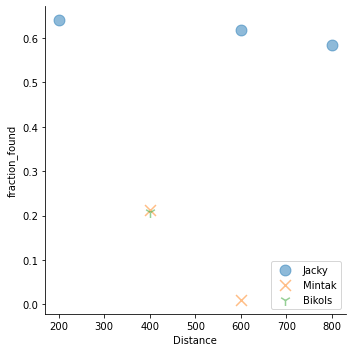

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
 
# give a list to the marker argument
sns.lmplot( x="Distance", y="fraction_found", data=df_final, fit_reg=False, hue='transect', legend=False, markers=["o", "x", "1"], scatter_kws={"s": 120, "alpha": 0.5})
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

plt.show()


## create test set

In [46]:
processed_path = '/home/jelle/Repositories/animalsounds/data/raven_annotations/sanaga_processed/'
path = '/run/user/1000/gvfs/dav:host=science.data.uu.nl,ssl=true/research-zwerts/data/sanaga/'
rec_main = 'A21'
rec_dist = 'A4'

df_main = read_processed_csv(processed_path, recorder = rec_main)

df_dist = read_processed_csv(processed_path, recorder = rec_dist)

dist_folder_stats = get_folder_stats(path, rec_dist)

df_main_subset = df_main[(df_main["start_datetime"] > dist_folder_stats[1]) & (df_main["end_datetime"] < dist_folder_stats[2])]
base_wav_path = '/run/user/1000/gvfs/dav:host=science.data.uu.nl,ssl=true/research-zwerts/data/sanaga/'

filelist = pd.DataFrame(wav_list(base_wav_path, rec_dist), columns=['filename'])
filelist['date_time'] = pd.to_datetime(filelist["filename"], format="%Y%m%d_%H%M%S")
filelist.tail(20)

,filename,date_time
7621,20210223_201300,2021-02-23 20:13:00
7622,20210223_201500,2021-02-23 20:15:00
7623,20210223_201700,2021-02-23 20:17:00
7624,20210223_202000,2021-02-23 20:20:00
7625,20210223_202600,2021-02-23 20:26:00
7626,20210223_202704,2021-02-23 20:27:04
7627,20210223_203000,2021-02-23 20:30:00
7628,20210223_203300,2021-02-23 20:33:00
7629,20210223_203600,2021-02-23 20:36:00
7630,20210223_204700,2021-02-23 20:47:00


In [30]:
#wav_path = base_wav_path+rec_dist+'/'
#filelengths = []
#for idx, row in filelist.iterrows():
#    print(row)
#    filelengths.append(librosa.get_duration(filename=wav_path + row['filename'] + '.WAV'))

filename         20210218_120747
date_time    2021-02-18 12:07:47
Name: 0, dtype: object
filename         20210218_120802
date_time    2021-02-18 12:08:02
Name: 1, dtype: object
filename         20210218_120902
date_time    2021-02-18 12:09:02
Name: 2, dtype: object
filename         20210218_121002
date_time    2021-02-18 12:10:02
Name: 3, dtype: object
filename         20210218_121102
date_time    2021-02-18 12:11:02
Name: 4, dtype: object
filename         20210218_121202
date_time    2021-02-18 12:12:02
Name: 5, dtype: object
filename         20210218_121302
date_time    2021-02-18 12:13:02
Name: 6, dtype: object
filename         20210218_121402
date_time    2021-02-18 12:14:02
Name: 7, dtype: object
filename         20210218_121502
date_time    2021-02-18 12:15:02
Name: 8, dtype: object
filename         20210218_121602
date_time    2021-02-18 12:16:02
Name: 9, dtype: object
filename         20210218_121702
date_time    2021-02-18 12:17:02
Name: 10, dtype: object
filename         202

KeyboardInterrupt: 

In [ ]:
#filelist['filelength'] = filelengths

In [26]:
# translate main annotation in dist annotations

df_new = pd.DataFrame(columns=["file", "offset", "duration"])
# create loop
for idx, row in df_main_subset.iterrows():
    print(row['start_datetime'])
    
    i = 0
    while filelist.iloc[i+1, 1]< row['start_datetime']:
         i += 1
        
    print(filelist.iloc[i,1])
    start = (row['start_datetime'] - filelist.iloc[i,1]).total_seconds()
    end_seconds = (row['end_datetime'] - filelist.iloc[i,1]).total_seconds()
    print(start)
            
    file = wav_path + filelist.iloc[i,0] + '.WAV'
    # check if file exists and is not corrupt (seconds to filestart < filelength)
    if start < filelist.iloc[i,2] and os.path.getsize(file) > 0:
        if end_seconds < filelist.iloc[i,2]:
            # create and append annotation row
            duration = end_seconds - start
            newrow = 
        else:
            
    else:
        #continue for loop
        print("file error")
#4 check if end time is < filelength

# if #4 is yes, check if next file exists
# create annotation row
# create and append rows

2021-02-18 14:44:16.008500
2021-02-18 14:44:02
14.0085
2021-02-18 14:54:20.993700
2021-02-18 14:54:02
18.9937
2021-02-18 16:43:07.494100
2021-02-18 16:43:02
5.4941
2021-02-18 17:04:16.116800
2021-02-18 17:04:02
14.1168
2021-02-18 17:10:39.175400
2021-02-18 17:10:02
37.1754
2021-02-18 17:17:09.042300
2021-02-18 17:17:02
7.0423
2021-02-18 17:18:17.187100
2021-02-18 17:18:02
15.1871
2021-02-18 17:18:37.208200
2021-02-18 17:18:02
35.2082
2021-02-18 17:35:51.346600
2021-02-18 17:35:02
49.3466
2021-02-18 17:43:04.905100
2021-02-18 17:43:02
2.9051
2021-02-18 18:42:53.414700
2021-02-18 18:42:02
51.4147
2021-02-18 23:30:03.952300
2021-02-18 23:30:02
1.9523
2021-02-18 23:30:15.058200
2021-02-18 23:30:02
13.0582
2021-02-18 23:31:20.795400
2021-02-18 23:31:02
18.7954
2021-02-18 23:32:24.312900
2021-02-18 23:32:02
22.3129
2021-02-18 23:32:30.528100
2021-02-18 23:32:02
28.5281
2021-02-18 23:34:31.483600
2021-02-18 23:34:02
29.4836
2021-02-18 23:35:14.389300
2021-02-18 23:35:02
12.3893
2021-02-18 23:

In [47]:
# for each main annotation check preceding filename
import librosa
import os
#main = deque(list(df_main_subset[["start_datetime", "end_datetime"]].itertuples(index=False, name=None)))
#dist = deque(list(df_dist[["start_datetime", "end_datetime"]].itertuples(index=False, name=None)))
base_wav_path = '/run/user/1000/gvfs/dav:host=science.data.uu.nl,ssl=true/research-zwerts/data/sanaga/'

filelist = pd.DataFrame(wav_list(base_wav_path, rec_dist), columns=['filename'])
filelist['date_time'] = pd.to_datetime(filelist["filename"], format="%Y%m%d_%H%M%S")

df_new = pd.DataFrame(columns=["file", "offset", "duration"])
df_main_emptylist = []

for j in list(df_main_subset.index):
    starttime = df_main_subset.loc[j,'start_datetime']
    endtime = df_main_subset.loc[j,'end_datetime']

    i=0
    while i < len(filelist)-2:
        
        if (filelist.iloc[i, 1] <= starttime and filelist.iloc[i+1, 1] > starttime):
            print("good")
            print(filelist.iloc[i, 0])
            print(df_main_subset.loc[j, 'begin_path'])
            
            
            # ADD check whether file exists (files

            # Check file lenght
            file_size = os.path.getsize(base_wav_path + rec_dist + '/' + filelist.iloc[i, 0] + '.WAV')
            
            if file_size == 0:
                print("file is empty")
                # remove from prediction set
                filelist = filelist.drop([filelist.index[i]])
                df_main_emptylist.append(j)
                break
            else:
                filelength = librosa.get_duration(filename=base_wav_path + rec_dist + '/' + filelist.iloc[i, 0] + '.WAV')
                print(filelength)
                # Calculate offset
                offset = (starttime - filelist.iloc[i, 1]).total_seconds()
                print("offset is " + str(offset) + " seconds")
                duration = (endtime - starttime).total_seconds()
                if offset > filelength:
                    print("recorder gap")
                    # What to do
                    df_main_emptylist.append(j)
                    break
                    
                if (offset+duration)>filelength:
                    print("Multifile")
                    while (offset+duration)>filelength and duration > 0.0 and i<len(filelist)-1:
                        ## Check if next file exists
                        file_size = os.path.getsize(base_wav_path + rec_dist + '/' + filelist.iloc[i+1, 0] + '.WAV')
                        if file_size == 0:
                            print("second file in multifile annotation is empty")
                            # This part should be removed from df_main
                            break
                            
                        duration_1 = filelength-offset

                        df_new = df_new.append({"file": filelist.iloc[i, 0] + '.WAV',
                                                "offset":  offset,
                                                "duration": duration_1,
                                                }, ignore_index=True)
                        i+=1
                        starttime_newfile = filelist.iloc[i,1]
                        duration = (endtime - starttime_newfile).total_seconds()
                        filelength = librosa.get_duration(filename=base_wav_path + rec_dist + '/' + filelist.iloc[i, 0] + '.WAV')
                        offset=0.0
                        

                    df_new = df_new.append({"file": filelist.iloc[i, 0] + '.WAV',
                                "offset":  offset,
                                "duration": duration,
                                }, ignore_index=True)
                    # create row,update offset check again, how to deal with index?
                else:
                    df_new = df_new.append({"file": filelist.iloc[i, 0] + '.WAV',
                                            "offset":  offset,
                                            "duration": duration,
                                            }, ignore_index=True)

            break

        i+=1

df_new

good
20210218_144402
20210218_144402
58.0
offset is 14.0085 seconds
good
20210218_145402
20210218_145402
58.0
offset is 18.9937 seconds
good
20210218_164302
20210218_164302
58.0
offset is 5.4941 seconds
good
20210218_170402
20210218_170402
58.0
offset is 14.1168 seconds
good
20210218_171002
20210218_171002
58.0
offset is 37.1754 seconds
good
20210218_171702
20210218_171702
58.0
offset is 7.0423 seconds
good
20210218_171802
20210218_171802
58.0
offset is 15.1871 seconds
good
20210218_171802
20210218_171802
58.0
offset is 35.2082 seconds
good
20210218_173502
20210218_173502
58.0
offset is 49.3466 seconds
good
20210218_174302
20210218_174302
58.0
offset is 2.9051 seconds
good
20210218_184202
20210218_184202
58.0
offset is 51.4147 seconds
good
20210218_233002
20210218_233002
58.0
offset is 1.9523 seconds
good
20210218_233002
20210218_233002
58.0
offset is 13.0582 seconds
good
20210218_233102
20210218_233102
58.0
offset is 18.7954 seconds
good
20210218_233202
20210218_233202
58.0
offset is 

,file,offset,duration
0,20210218_144402.WAV,14.0085,11.156799
1,20210218_145402.WAV,18.9937,10.443579
2,20210218_164302.WAV,5.4941,2.037771
3,20210218_170402.WAV,14.1168,5.349150
4,20210218_171002.WAV,37.1754,0.662275
...,...,...,...
466,20210222_013304.WAV,51.4249,4.575100
467,20210222_013404.WAV,0.0000,7.600691
468,20210222_110604.WAV,0.0000,12.028945
469,20210222_111004.WAV,52.9050,3.095000


In [48]:
folder = 'A4'
output_path = '/home/jelle/Repositories/animalsounds/data/raven_annotations/sanaga_test/chimpanzee/'
df_new.to_csv(output_path + folder + '.csv')

In [50]:
df = pd.read_csv('/home/jelle/Repositories/animalsounds/data/raven_annotations/sanaga_test/chimpanzee/' + folder + '.csv')
df.head()

yodapath = '/nluu6p/home/research-zwerts/data/sanaga/' + folder + '/'
destination = '/home/jelle/Repositories/animalsounds/data/sanaga/' + folder + '/'

# create Unique list 
for file in list(df['file'].unique()):
    
    print(file)
    yoda_get(file, yodapath, destination)
    
annotations_path = '/home/jelle/Repositories/animalsounds/data/sanaga/' + folder + '/'
output_path = '/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/' + folder + '/'

for index, row in df.iterrows():
    # Open
    filepath = annotations_path + row['file']
    y, sr = librosa.load(filepath, sr=48000,
                             offset=row['offset'],
                             duration=row['duration'])
    outfile = (output_path + str(index) + '_sanaga_' + row['file'][0:-4] + '_' + str(row['offset']) + '.wav')
    print(outfile)
    sf.write(outfile, y, sr)

20210218_144402.WAV
20210218_145402.WAV
20210218_164302.WAV
20210218_170402.WAV
20210218_171002.WAV
20210218_171702.WAV
20210218_171802.WAV
20210218_173502.WAV
20210218_174302.WAV
20210218_184202.WAV
20210218_233002.WAV
20210218_233102.WAV
20210218_233202.WAV
20210218_233402.WAV
20210218_233502.WAV
20210218_233702.WAV
20210218_233802.WAV
20210218_233902.WAV
20210218_234002.WAV
20210218_234102.WAV
20210218_234202.WAV
20210218_234302.WAV
20210218_234402.WAV
20210218_234502.WAV
20210218_234602.WAV
20210218_234802.WAV
20210218_235002.WAV
20210218_235202.WAV
20210218_235302.WAV
20210218_235402.WAV
20210218_235502.WAV
20210218_235702.WAV
20210219_033102.WAV
20210219_033302.WAV
20210219_033502.WAV
20210219_033602.WAV
20210219_033902.WAV
20210219_034002.WAV
20210219_034102.WAV
20210219_034202.WAV
20210219_034302.WAV
20210219_034402.WAV
20210219_034502.WAV
20210219_034602.WAV
20210219_072502.WAV
20210219_074702.WAV
20210219_091702.WAV
20210219_091902.WAV
20210219_093002.WAV
20210219_103602.WAV


In [41]:
# 
import librosa
import soundfile as sf

annotations_path = '/home/jelle/Repositories/animalsounds/data/sanaga/' + folder + '/'
output_path = '/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/' + folder + '/'

for index, row in df.iterrows():
    # Open
    filepath = annotations_path + row['file']
    y, sr = librosa.load(filepath, sr=48000,
                             offset=row['offset'],
                             duration=row['duration'])
    outfile = (output_path + str(index) + '_sanaga_' + row['file'][0:-4] + '_' + str(row['offset']) + '.wav')
    print(outfile)
    sf.write(outfile, y, sr)


/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A1/0_sanaga_20210218_144402_14.0085.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A1/1_sanaga_20210218_145402_18.9937.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A1/2_sanaga_20210218_164302_5.4941.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A1/3_sanaga_20210218_170402_14.1168.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A1/4_sanaga_20210218_171002_37.1754.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A1/5_sanaga_20210218_171702_7.0423.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A1/6_sanaga_20210218_171802_15.1871.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A1/7_sanaga_20210218_171802_35.2082.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A1/8_sanaga_20210218_173502_49.3466.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A1/9_sanaga_20210218_1

In [57]:
# for Sanaga processed csv format (only run for main recorders)

folder = 'A38'
file = '/home/jelle/Repositories/animalsounds/data/raven_annotations/sanaga_processed/' + folder + '.csv'
df = pd.read_csv(file)

In [58]:
yodapath = '/nluu6p/home/research-zwerts/data/sanaga/' + folder + '/'
destination = '/home/jelle/Repositories/animalsounds/data/sanaga/' + folder + '/'

# create Unique list 
for file in list(df['begin_path'].unique()):
    
    print(file)
    yoda_get(file + '.WAV', yodapath, destination)

20210218_171702
20210218_171802
20210218_172802
20210218_181702
20210218_183102
20210218_184802
20210218_185602
20210218_190202
20210218_232802
20210218_233002
20210218_233102
20210218_233202
20210218_233302
20210218_233402
20210218_233502
20210218_233702
20210218_233802
20210218_233902
20210218_234002
20210218_234202
20210218_234302
20210218_234602
20210218_234802
20210218_235002
20210218_235102
20210218_235202
20210218_235302
20210218_235402
20210218_235502
20210218_235702
20210219_033102
20210219_033302
20210219_033502
20210219_033602
20210219_033902
20210219_034002
20210219_034103
20210219_034202
20210219_034402
20210219_034602
20210219_064202
20210219_103802
20210219_104102
20210219_104402
20210219_104702
20210219_104802
20210219_110502
20210219_111102
20210219_111302
20210219_111502
20210219_111602
20210219_111802
20210219_122602
20210219_133902
20210219_141502
20210219_141802
20210219_171202
20210219_171302
20210219_235402
20210219_235502
20210219_235602
20210219_235702
20210219

In [59]:
import librosa
import soundfile as sf

annotations_path = '/home/jelle/Repositories/animalsounds/data/sanaga/' + folder + '/'
output_path = '/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/' + folder + '/'

for index, row in df.iterrows():
    # Open
    filepath = annotations_path + row['begin_path'] + '.WAV'
    duration = row['end_time']-row['start_time']
    y, sr = librosa.load(filepath, sr=48000,
                             offset=row['start_time'],
                             duration=duration)
    outfile = (output_path + str(index) + '_sanaga_' + row['begin_path'] + '_' + str(row['start_time']) + '.wav')
    print(outfile)
    sf.write(outfile, y, sr)

/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/0_sanaga_20210218_171702_9.9911.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/1_sanaga_20210218_171802_15.5325.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/2_sanaga_20210218_172802_32.7483.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/3_sanaga_20210218_181702_21.1141.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/4_sanaga_20210218_183102_31.182.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/5_sanaga_20210218_184802_1.9564.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/6_sanaga_20210218_185602_1.9595.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/7_sanaga_20210218_190202_27.0867.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/8_sanaga_20210218_232802_37.1713.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/9_sanaga_20

/home/jelle/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/217_sanaga_20210221_091303_18.8201.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/218_sanaga_20210221_091703_19.6536.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/219_sanaga_20210221_091703_34.1654.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/220_sanaga_20210221_091903_38.2324.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/221_sanaga_20210221_092103_16.1724.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/222_sanaga_20210221_092803_43.7342.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/223_sanaga_20210221_093203_6.8407.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/224_sanaga_20210221_100503_6.0438.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/225_sanaga_20210221_100603_16.3708.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/ch

/home/jelle/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/282_sanaga_20210222_055204_28.2217.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/283_sanaga_20210222_055304_14.7552.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/284_sanaga_20210222_055304_41.7315.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/285_sanaga_20210222_055504_35.6496.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/286_sanaga_20210222_055604_6.9836.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/287_sanaga_20210222_055904_22.889.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/288_sanaga_20210222_072804_36.3562.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/289_sanaga_20210222_073304_17.3992.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/290_sanaga_20210222_073304_31.4454.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/ch

/home/jelle/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/363_sanaga_20210223_105505_25.3231.wav


/home/jelle/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/364_sanaga_20210223_105505_47.2853.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/365_sanaga_20210223_110505_18.482.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/366_sanaga_20210223_110604_37.79.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/367_sanaga_20210223_111204_11.5038.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/368_sanaga_20210223_111505_23.4226.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/369_sanaga_20210223_111705_6.6472.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/370_sanaga_20210223_112204_13.1301.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/371_sanaga_20210223_112204_20.9471.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chimps/A38/372_sanaga_20210223_131604_49.3226.wav
/home/jelle/Repositories/animalsounds/data/sanaga_test/chim